This notebook contains the solutions k=2, 4 for periods 1 and 4 for the case in which the PCA is carried out without the fire season.

In [1]:
import pandas as pd
import geopandas as gpd
from functools import reduce
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
# import plotly
# plotly.offline.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as mcl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.patches import Patch, Ellipse
from shapely.geometry.point import Point
mpl.rcParams['figure.dpi']= 300
plt.rcParams['text.usetex'] = False
# mpl.rcParams['text.usetex'] = True
mpl.rc('font',family='Arial')

from matplotlib.colors import rgb2hex

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# User inputs
grid_id = '30km'

# Periods we are working with
nperiods = 4
nyears = 9

# list of fire variables
fire_vars = ['size_q50', 'size_q99', 'number_fires_n', 'burned_area_n', 'season_q50s', 'frequency_q99s']
# List of transformed fire variables
# fire_vars_t = ['log_size_q50', 'log_size_q99', 'log_number_fires_n', 'log_burned_area_n', 'season_q50s', 'log1_frequency_q99s']
fire_vars_t = ['log_size_q50', 'log_size_q99', 'log_burned_area_n', 'log_number_fires_n', 'log1_frequency_q99s', 'season_q50s']

# Labels to name the PCA components
# pca_comp_labels = ['Logarithm of median fire size', 'Logarithm of 99th fire size', 'Logarithm of number fires', 'Logarithm of burned area', 'Median fire season', 'Logarithm of 99th frequency']
pca_comp_labels_1 = ['Log. 99th fire size', 'Log. median fire size', 'Log. burned area', 'Log. number fires', 'Log. 99th frequency']
# pca_comp_labels = ['Log. median fire size', 'Log. 99th fire size', 'Log. burned area', 'Log. number fires', 'Log. 99th frequency', 'Peak fire season']


## Using k=4 for first period and k=2 for last period (the ones indicated by BIC)

In [26]:
cmap = plt.get_cmap('tab20')
list_colors = [mcl.rgb2hex(cmap(i)) for i in range(cmap.N)]

pal_p14 = {
    'p1' : {'AP1_noSeason' : '#117733',
            'BP1_noSeason' : '#882255',
            'CP1_noSeason' : '#DDCC77', # '#6fa8dc',
            'DP1_noSeason' : '#88CCEE', # '#eeeeee',
           },

    'p4' : {'BP4_noSeason' : '#EE6677', # list_colors[1],
            'CP4_noSeason' : '#CCBB44'} # list_colors[2]}
}

In [27]:
# Identifier between numeric and alphabetical
alpha_id = {
    'p1' : {1 : 'DP1_noSeason',
            2 : 'BP1_noSeason',
            3 : 'CP1_noSeason',
            4 : 'AP1_noSeason'},

    'p4' : {1 : 'CP4_noSeason',
            2 : 'BP4_noSeason'}
}

In [28]:
# Reading data for each period
grid = gpd.read_file('../../data/shapes/cerrado_grid_{}_cropped.shp'.format(grid_id))[['id','geometry']]

data = dict()
pca_comp = dict()

for period, klist in zip([1, 4], [[4, 2], [2,4]]):
    # Classification solutions for each k
    class_k = pd.read_csv('../../analysis_new_grids/{}_year_periods/fS_int_noSeas/constClusteringClass_ksolutions_grid{}_period{}.csv'.format(nyears, grid_id, period))
    # Keeping only relevant columns
    class_k = class_k[['id'] + ['clust_{}'.format(k) for k in klist]]

    # PCA scores for period
    pca_dir = '../../data_new_grids/processed/clustering_algorithm/fS_int_noSeas/'.format(nyears)
    scores = pd.read_csv(pca_dir + 'PCAscores_scaling1_sites_input_vars_transformed_grid{}_period{}.csv'.format(grid_id, period))
    pca_comp['p{}'.format(period)] = pd.read_csv(pca_dir + 'PCAscores_scaling1_species_input_vars_transformed_grid{}_period{}.csv'.format(grid_id, period))
    
    # Add column with labels
    pca_comp['p{}'.format(period)]['id_label'] = pca_comp_labels_1

    # Merging all data
    data['p{}'.format(period)] = reduce(lambda df1, df2: pd.merge(df1, df2, on='id'), [grid, class_k, scores])
    
    # # Adding alphabetical and color-code information per solution k
    # for k in klist:
    # # Create alphanumeric relation to relate the numeric identifier to a letter
    # alphanumeric_relation = dict(zip(range(1, k+1), [chr(x) for x in range(65, 65 + k)]))
    k = klist[0]
    # Casting as column
    data['p{}'.format(period)]['clust_alpha_{}'.format(k)] = [alpha_id['p{}'.format(period)][v] for v in data['p{}'.format(period)]['clust_{}'.format(k)]] #[alphanumeric_relation[v] for v in data['p{}'.format(period)]['clust_{}'.format(k)]]

    # Adding colour-code information as column
    data['p{}'.format(period)]['colors_{}'.format(k)] = [pal_p14['p{}'.format(period)][v] for v in data['p{}'.format(period)]['clust_alpha_{}'.format(k)]]
    
    # if period in [1,4]:
    #     k = klist[1]
    #     # Adding colour-code information as column
    #     data['p{}'.format(period)]['colors_{}'.format(k)] = [pal_p14_2['p{}'.format(period)][v] for v in data['p{}'.format(period)]['clust_{}'.format(k)]]
        

# Reading the explanaotry power of the PCA axes
pca_exp = pd.read_csv('../../data_new_grids/processed/clustering_algorithm/PCAexpPower_scaling1_sites_input_vars_transformed_grid{}.csv'.format(grid_id))

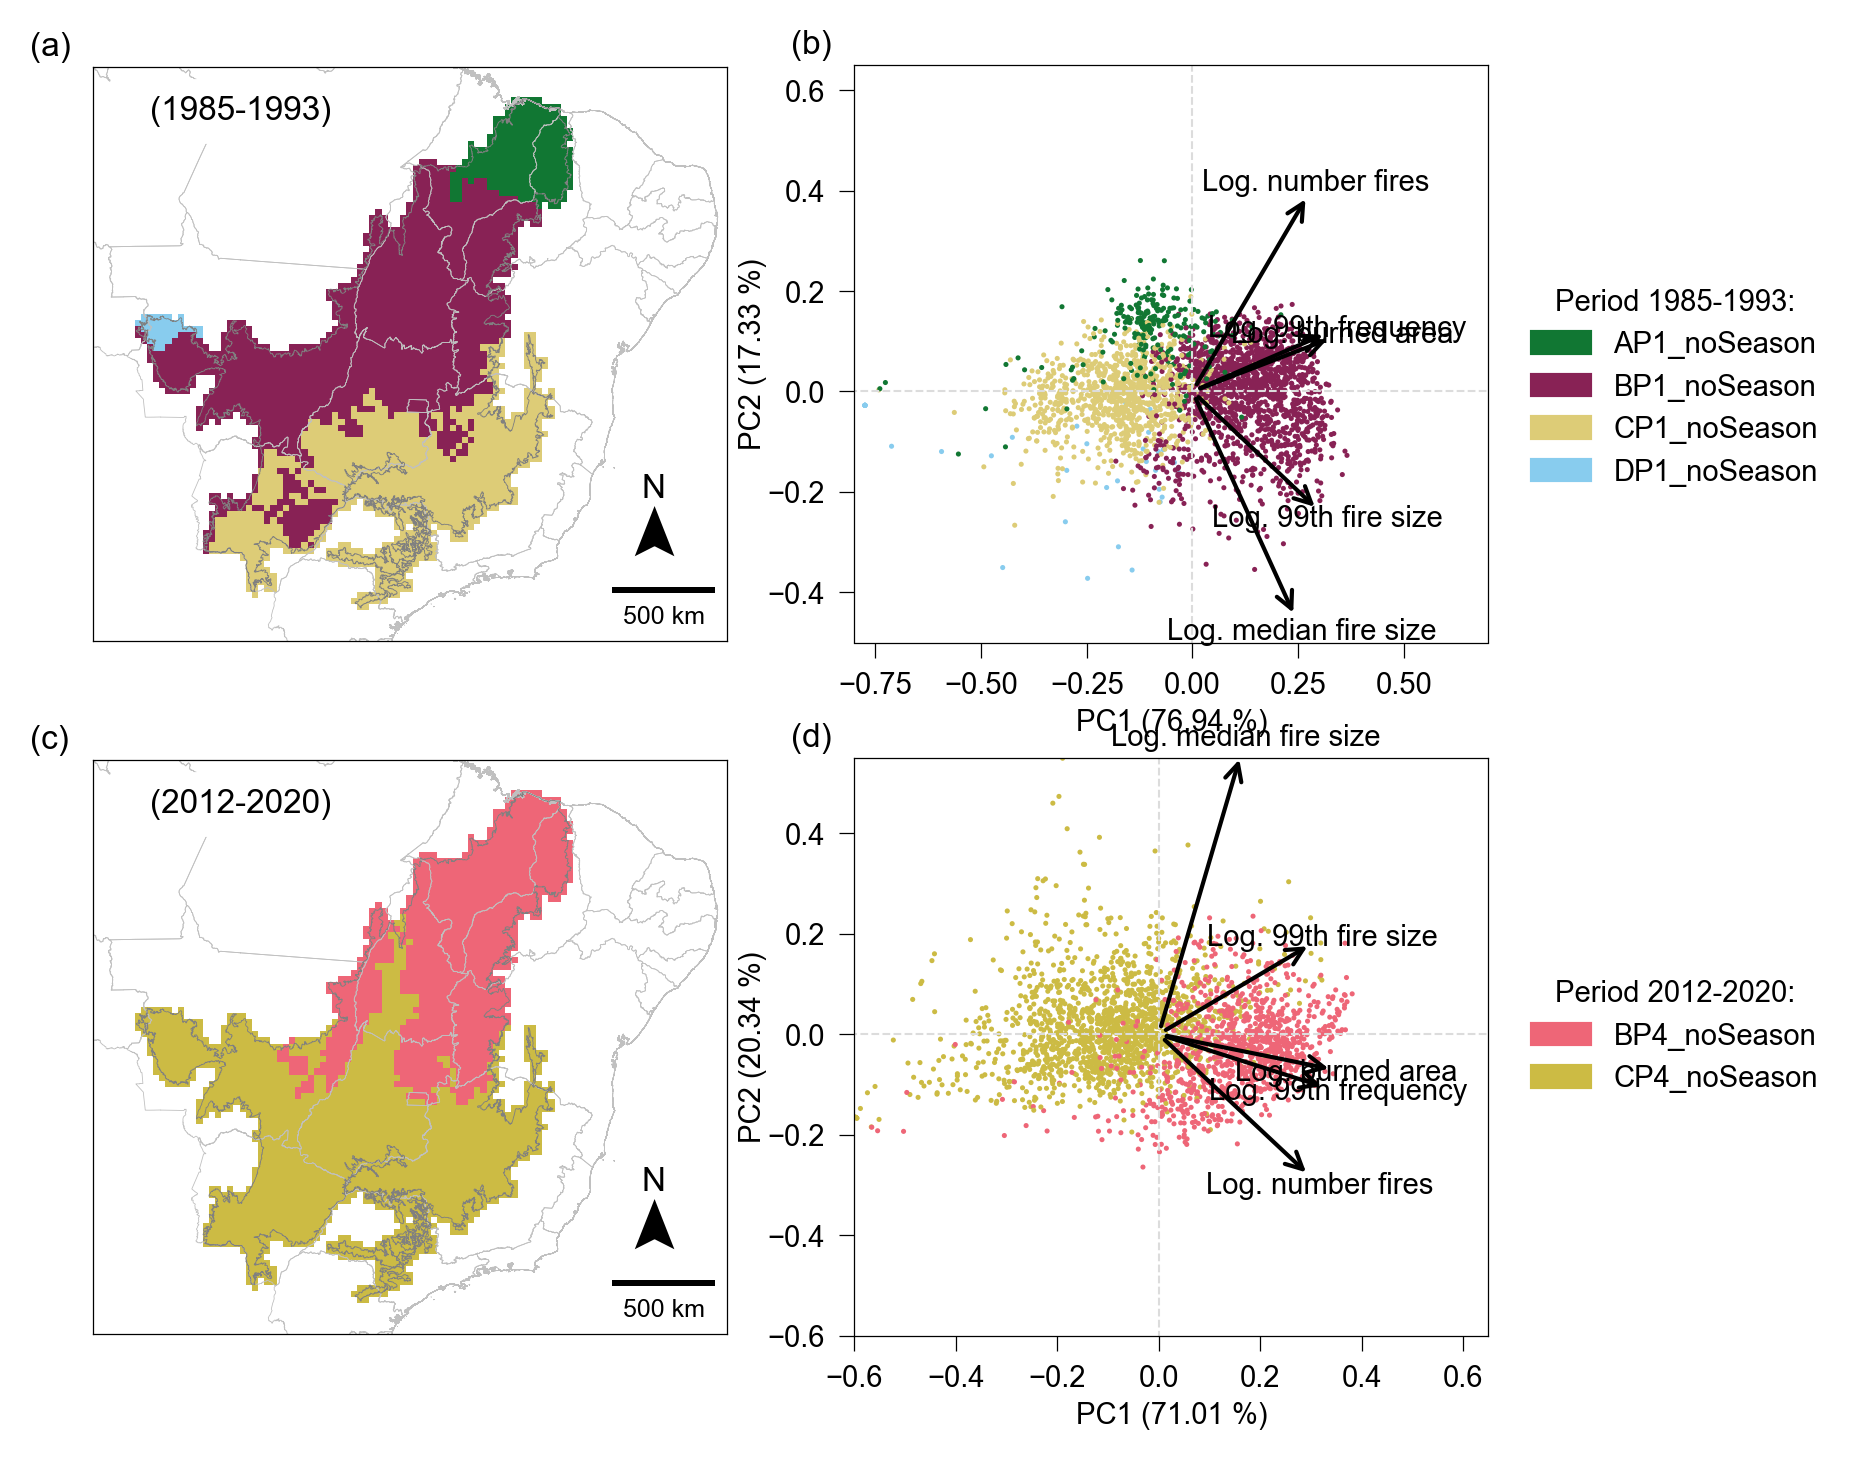

In [29]:
fig, axes = plt.subplots(2, 2, figsize = (6., 5.5))

pca_lim = [((-0.8, 0.7), (-0.5, 0.65)), ((-0.6, 0.65), (-0.6, 0.55))]

fig_label = ['(a)', '(c)', '(b)',  '(d)']

# Plot for each solution (number of clusters)
i = 0
for i, period, k, p_label, (xlim, ylim) in zip(range(2), [1, 4], [4, 2], ['(1985-1993)', '(2012-2020)'], pca_lim):
    
    toPlot = data['p{}'.format(period)].copy()
    
    # Inverting x-axes of period's 4 PCA
    if period == 4:
        toPlot['PC1'] = (-1) * toPlot['PC1']
    
    # ----------------------------------------------------------------------------------------------------------------------
    # Map on top
    toPlot.plot(color = toPlot['colors_{}'.format(k)], ax = axes[i][0], legend = True)
    # axes[i][0].set_axis_off()
    # axes[i][0].set_title(p_label, fontsize = 8)
    
    br_states = gpd.read_file('../../data/shapes/brazilian_states/gadm36_BRA_1.shp')
    br_states = br_states.to_crs(toPlot.crs)
    br_states.boundary.plot(ax = axes[i][0], linewidth=0.2, edgecolor = 'silver')
    

    cerrado = gpd.read_file('../../data/shapes/cerrado_1-250000.shp')
    cerrado = cerrado.to_crs(toPlot.crs)
    cerrado.boundary.plot(ax = axes[i][0], linewidth=0.2, edgecolor = 'grey')
    
    minx, miny, maxx, maxy = toPlot.total_bounds
    axes[i][0].set_xlim(minx-200000, maxx+750000)
    axes[i][0].set_ylim(miny-150000, maxy+150000)
    
    
    # Adding figure label
    axes[i][0].text(x=-0.1, y=1.02, s=fig_label[i], transform=axes[i][0].transAxes, fontsize=8)
    
    axes[i][0].tick_params(axis='both', 
                            which='both',
                            bottom=False,
                            left = False,
                            labelbottom=False, labelleft = False)
    
    # Change width of all spines of axis
    for axis in ['top','bottom','left','right']:
        axes[i][0].spines[axis].set_linewidth(0.3)
        
    # Adding label with the period
    axes[i][0].text(0.375, 0.95, p_label, transform = axes[i][0].transAxes, fontsize=8, bbox = {'edgecolor': 'white', 'facecolor':'white', 'linewidth':0.2}, va = 'top', ha = 'right') # , backgroundcolor='white'
    
    # Including an arrow
    axes[i][0].text(x=0.865, y=0.25, s='N', transform=axes[i][0].transAxes, fontsize=8)
    # 0.055 for the 4-grid, 0.05 for the 3-grid
    axes[i][0].arrow(0.885, 0.175, 0.0, 0.05, length_includes_head=True, transform=axes[i][0].transAxes,
              width = 0, head_width=0.05, head_length=0.07, overhang=0.2, facecolor='k')
    
    # Taken from the GeoPandas documentation: https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html 
    points = gpd.GeoSeries([Point(-45, -10.0), Point(-46, -10.0)], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs('epsg:5880') # Projected WGS 84 - meters
    distance_meters = points[0].distance(points[1])

    # axes[i][0].add_artist(ScaleBar(distance_meters, location='lower right', font_properties={'size': 8}, sep = 3))
    axes[i][0].add_artist(ScaleBar(dx = 1, units = 'm', dimension = 'si-length',  location='lower right', font_properties={'size': 6}, sep = 3))
    
    # # Add zone that is a bit special
    # if period == 4:
    #     subset = toPlot[toPlot['clust_{}'.format(kp4_2)] == 2]
    #     subset.dissolve().boundary.plot(color = '#4c31db', ax = axes[i][0], linewidth = 0.6)
    # ----------------------------------------------------------------------------------------------------------------------
    # PCA at the bottom
    
    # Setting the limits of the axis manually
    axes[i][1].set_xlim(xlim)
    axes[i][1].set_ylim(ylim)
    
    # Adding vertical and horizontal lines
    axes[i][1].axvline(0, -1, 1, linestyle = '--', linewidth = 0.5, color = 'gainsboro')
    axes[i][1].axhline(0, -1, 1, linestyle = '--', linewidth = 0.5, color = 'gainsboro')
    
    # Adding figure label
    axes[i][1].text(x=-0.1, y=1.02, s=fig_label[i+2], transform=axes[i][1].transAxes, fontsize=8)
    
    # The data points
    _plot = sns.scatterplot(x = toPlot['PC1'],
                    y = toPlot['PC2'],
                    hue = toPlot['clust_alpha_{}'.format(k)], 
                    ax = axes[i][1], s = 1.5, edgecolor = 'none', legend = None, palette = pal_p14['p{}'.format(period)])
    
    pca_exp_x = np.round(pca_exp.loc[pca_exp['period'] == period, 'PC1'].item(), decimals = 2)
    pca_exp_y = np.round(pca_exp.loc[pca_exp['period'] == period, 'PC2'].item() - pca_exp_x, decimals = 2)
    
    axes[i][1].set_xlabel('PC1 ({} %)'.format(pca_exp_x), fontsize = 7, labelpad = 2)
    axes[i][1].set_ylabel('PC2 ({} %)'.format(pca_exp_y), fontsize = 7, labelpad = 0.25)
    
    
    # Changing width of plot lines
    axes[i][1].tick_params(axis='both', which='major', labelsize=7, width = 0.3)
    # Change width of all spines of axis
    for axis in ['top','bottom','left','right']:
        axes[i][1].spines[axis].set_linewidth(0.3)
        
    # Adding the arrows
    comp = pca_comp['p{}'.format(period)].copy()
    # Inverting x-axes for period 4
    if period == 4:
        comp['PC1'] = (-1)* comp['PC1']
    for c in range(len(comp)):
        sc = 16
        # axes[i][1].arrow(0, 0, comp.loc[c,'PC1']/sc, comp.loc[c, 'PC2']/sc, color = 'r', width = 0.0001)
        axes[i][1].annotate('', xy = (0, 0),# xycoords = 'data',
                  xytext = (comp.loc[c,'PC1']/sc, comp.loc[c, 'PC2']/sc),# textcoords = 'data',
                  arrowprops = {'arrowstyle':'<-','edgecolor' : 'black', 'facecolor': 'black'})

        axes[i][1].text(comp.loc[c,'PC1']*1.05/sc, comp.loc[c, 'PC2']*1.05/sc, comp.loc[c, 'id_label'], fontsize = 7, color = 'black', ha = 'center', va = 'center')
        
    # # Add zone that is a bit special
    # if period == 4:
    #     subset = toPlot[toPlot['clust_{}'.format(kp4_2)] == 2].reset_index(drop = True)
    #     # The data points
    #     sns.scatterplot(x = subset['PC1'],
    #                     y = subset['PC2'],
    #                     hue = subset['clust_alpha_{}'.format(k)], 
    #                     ax = axes[i][1], s = 1.5,  legend = None, palette = pal_p14['p{}'.format(period)], linewidth = 0.5, edgecolor = '#4c31db')
    del toPlot, comp
        
    i += 1
    
    
# Create legend manually
patches_p1 = [Patch(color = c, label = l) for c, l in zip(pal_p14['p1'].values(), pal_p14['p1'].keys())]
patches_p4 = [Patch(color = c, label = l) for c, l in zip(pal_p14['p4'].values(), pal_p14['p4'].keys())]

legend_contents = [Patch(visible = False, label = 'Period 1985-1993:')] + patches_p1 + [Patch(visible = False, label = ''), Patch(visible = False, label = 'Period 2012-2020:')] + patches_p4

legend_p1 = plt.legend(handles = patches_p1, title ='Period 1985-1993:', loc = (1.05, 1.45), fontsize = 7, title_fontsize = 7, frameon = False)
plt.legend(handles = patches_p4, title ='Period 2012-2020:', loc = (1.05, .4), fontsize = 7, title_fontsize = 7, frameon = False)
plt.gca().add_artist(legend_p1)

# plt.savefig('../plots_colorblind/map_PCA_periods1_4.png', dpi=300, facecolor='white', transparent=False, bbox_inches="tight")
# plt.savefig('../plots_colorblind/map_PCA_periods1_4.pdf', dpi=300, facecolor='white', transparent=False, bbox_inches="tight")
# plt.show()

## Using k=4 for first period and k=2 for last period (the ones indicated by BIC)

In [45]:
cmap = plt.get_cmap('tab20')
list_colors = [mcl.rgb2hex(cmap(i)) for i in range(cmap.N)]

pal_p14 = {
    'p1' : {'AP1_noSeason' : '#117733',
            'BP1_noSeason' : '#882255',
            'CP1_noSeason' : '#DDCC77', # '#6fa8dc',
            'DP1_noSeason' : '#88CCEE', # '#eeeeee',
           },

    'p4' : {'AP4_noSeason' : '#228833', # list_colors[0],
            'BP4_noSeason' : '#EE6677', # list_colors[1],
            'CP4_noSeason' : '#CCBB44',
            'DP4_noSeason' : '#66CCEE'} # list_colors[2]}
}

In [46]:
# Identifier between numeric and alphabetical
alpha_id = {
    'p1' : {1 : 'DP1_noSeason',
            2 : 'BP1_noSeason',
            3 : 'CP1_noSeason',
            4 : 'AP1_noSeason'},

    'p4' : {2 : 'CP4_noSeason',
            3 : 'BP4_noSeason',
            4 : 'AP4_noSeason',
            1 : 'DP4_noSeason'}
}

In [47]:
# Reading data for each period
grid = gpd.read_file('../../data/shapes/cerrado_grid_{}_cropped.shp'.format(grid_id))[['id','geometry']]

data = dict()
pca_comp = dict()

for period, klist in zip([1, 4], [[4, 2], [4,2]]):
    # Classification solutions for each k
    class_k = pd.read_csv('../../analysis_new_grids/{}_year_periods/fS_int_noSeas/constClusteringClass_ksolutions_grid{}_period{}.csv'.format(nyears, grid_id, period))
    # Keeping only relevant columns
    class_k = class_k[['id'] + ['clust_{}'.format(k) for k in klist]]

    # PCA scores for period
    pca_dir = '../../data_new_grids/processed/clustering_algorithm/fS_int_noSeas/'.format(nyears)
    scores = pd.read_csv(pca_dir + 'PCAscores_scaling1_sites_input_vars_transformed_grid{}_period{}.csv'.format(grid_id, period))
    pca_comp['p{}'.format(period)] = pd.read_csv(pca_dir + 'PCAscores_scaling1_species_input_vars_transformed_grid{}_period{}.csv'.format(grid_id, period))
    
    # Add column with labels
    pca_comp['p{}'.format(period)]['id_label'] = pca_comp_labels_1

    # Merging all data
    data['p{}'.format(period)] = reduce(lambda df1, df2: pd.merge(df1, df2, on='id'), [grid, class_k, scores])
    
    # # Adding alphabetical and color-code information per solution k
    # for k in klist:
    # # Create alphanumeric relation to relate the numeric identifier to a letter
    # alphanumeric_relation = dict(zip(range(1, k+1), [chr(x) for x in range(65, 65 + k)]))
    k = klist[0]
    # Casting as column
    data['p{}'.format(period)]['clust_alpha_{}'.format(k)] = [alpha_id['p{}'.format(period)][v] for v in data['p{}'.format(period)]['clust_{}'.format(k)]] #[alphanumeric_relation[v] for v in data['p{}'.format(period)]['clust_{}'.format(k)]]

    # Adding colour-code information as column
    data['p{}'.format(period)]['colors_{}'.format(k)] = [pal_p14['p{}'.format(period)][v] for v in data['p{}'.format(period)]['clust_alpha_{}'.format(k)]]
    
    # if period in [1,4]:
    #     k = klist[1]
    #     # Adding colour-code information as column
    #     data['p{}'.format(period)]['colors_{}'.format(k)] = [pal_p14_2['p{}'.format(period)][v] for v in data['p{}'.format(period)]['clust_{}'.format(k)]]
        

# Reading the explanaotry power of the PCA axes
pca_exp = pd.read_csv('../../data_new_grids/processed/clustering_algorithm/PCAexpPower_scaling1_sites_input_vars_transformed_grid{}.csv'.format(grid_id))

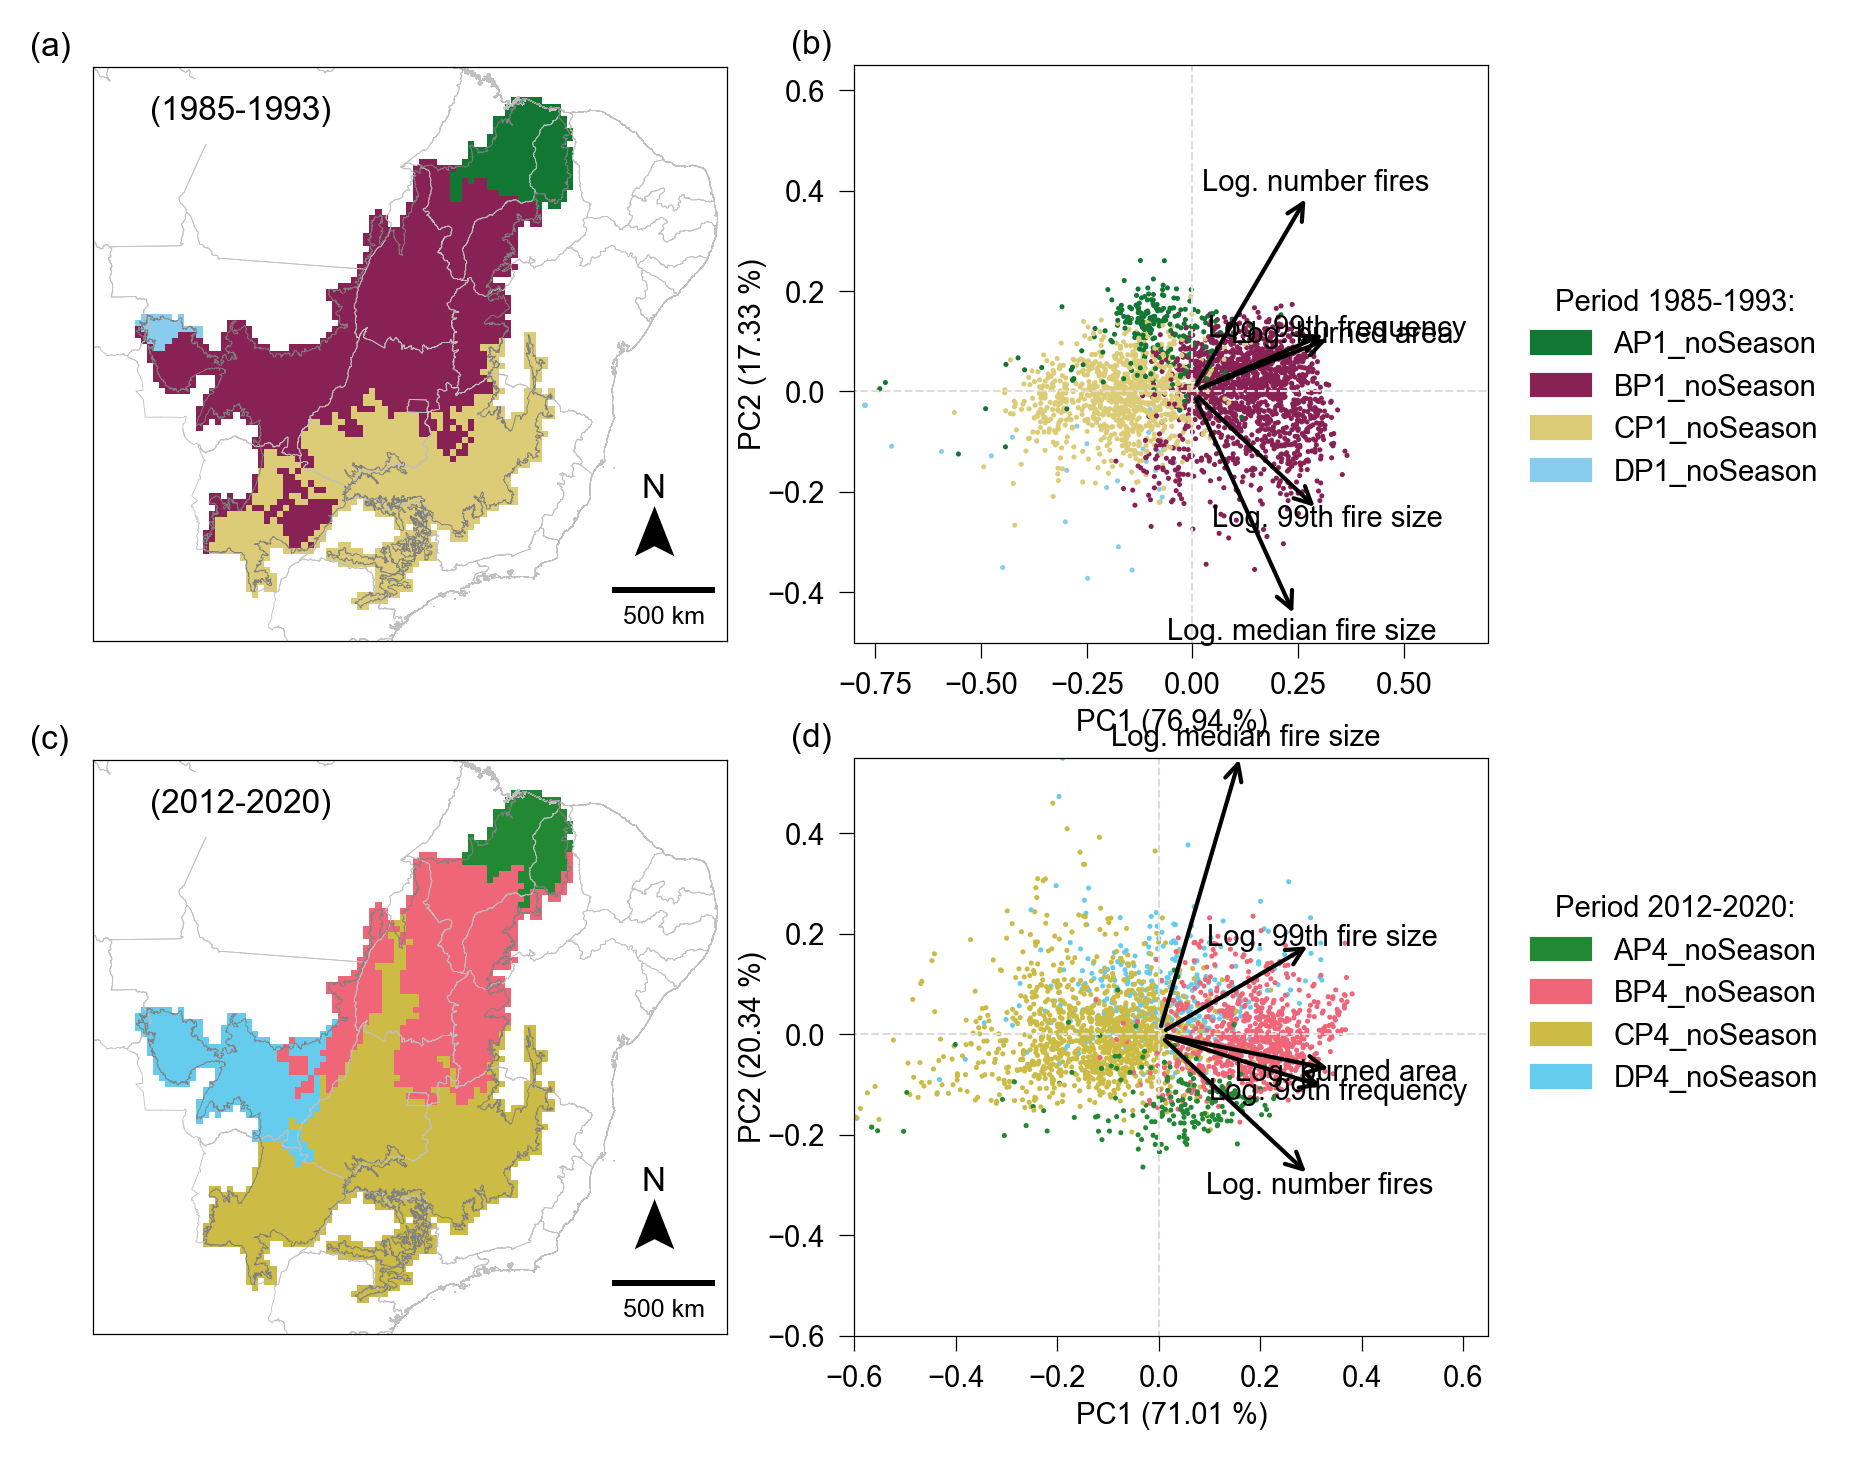

In [48]:
fig, axes = plt.subplots(2, 2, figsize = (6., 5.5))

pca_lim = [((-0.8, 0.7), (-0.5, 0.65)), ((-0.6, 0.65), (-0.6, 0.55))]

fig_label = ['(a)', '(c)', '(b)',  '(d)']

# Plot for each solution (number of clusters)
i = 0
for i, period, k, p_label, (xlim, ylim) in zip(range(2), [1, 4], [4, 4], ['(1985-1993)', '(2012-2020)'], pca_lim):
    
    toPlot = data['p{}'.format(period)].copy()
    
    # Inverting x-axes of period's 4 PCA
    if period == 4:
        toPlot['PC1'] = (-1) * toPlot['PC1']
    
    # ----------------------------------------------------------------------------------------------------------------------
    # Map on top
    toPlot.plot(color = toPlot['colors_{}'.format(k)], ax = axes[i][0], legend = True)
    # axes[i][0].set_axis_off()
    # axes[i][0].set_title(p_label, fontsize = 8)
    
    br_states = gpd.read_file('../../data/shapes/brazilian_states/gadm36_BRA_1.shp')
    br_states = br_states.to_crs(toPlot.crs)
    br_states.boundary.plot(ax = axes[i][0], linewidth=0.2, edgecolor = 'silver')
    

    cerrado = gpd.read_file('../../data/shapes/cerrado_1-250000.shp')
    cerrado = cerrado.to_crs(toPlot.crs)
    cerrado.boundary.plot(ax = axes[i][0], linewidth=0.2, edgecolor = 'grey')
    
    minx, miny, maxx, maxy = toPlot.total_bounds
    axes[i][0].set_xlim(minx-200000, maxx+750000)
    axes[i][0].set_ylim(miny-150000, maxy+150000)
    
    
    # Adding figure label
    axes[i][0].text(x=-0.1, y=1.02, s=fig_label[i], transform=axes[i][0].transAxes, fontsize=8)
    
    axes[i][0].tick_params(axis='both', 
                            which='both',
                            bottom=False,
                            left = False,
                            labelbottom=False, labelleft = False)
    
    # Change width of all spines of axis
    for axis in ['top','bottom','left','right']:
        axes[i][0].spines[axis].set_linewidth(0.3)
        
    # Adding label with the period
    axes[i][0].text(0.375, 0.95, p_label, transform = axes[i][0].transAxes, fontsize=8, bbox = {'edgecolor': 'white', 'facecolor':'white', 'linewidth':0.2}, va = 'top', ha = 'right') # , backgroundcolor='white'
    
    # Including an arrow
    axes[i][0].text(x=0.865, y=0.25, s='N', transform=axes[i][0].transAxes, fontsize=8)
    # 0.055 for the 4-grid, 0.05 for the 3-grid
    axes[i][0].arrow(0.885, 0.175, 0.0, 0.05, length_includes_head=True, transform=axes[i][0].transAxes,
              width = 0, head_width=0.05, head_length=0.07, overhang=0.2, facecolor='k')
    
    # Taken from the GeoPandas documentation: https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html 
    points = gpd.GeoSeries([Point(-45, -10.0), Point(-46, -10.0)], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs('epsg:5880') # Projected WGS 84 - meters
    distance_meters = points[0].distance(points[1])

    # axes[i][0].add_artist(ScaleBar(distance_meters, location='lower right', font_properties={'size': 8}, sep = 3))
    axes[i][0].add_artist(ScaleBar(dx = 1, units = 'm', dimension = 'si-length',  location='lower right', font_properties={'size': 6}, sep = 3))
    
    # # Add zone that is a bit special
    # if period == 4:
    #     subset = toPlot[toPlot['clust_{}'.format(kp4_2)] == 2]
    #     subset.dissolve().boundary.plot(color = '#4c31db', ax = axes[i][0], linewidth = 0.6)
    # ----------------------------------------------------------------------------------------------------------------------
    # PCA at the bottom
    
    # Setting the limits of the axis manually
    axes[i][1].set_xlim(xlim)
    axes[i][1].set_ylim(ylim)
    
    # Adding vertical and horizontal lines
    axes[i][1].axvline(0, -1, 1, linestyle = '--', linewidth = 0.5, color = 'gainsboro')
    axes[i][1].axhline(0, -1, 1, linestyle = '--', linewidth = 0.5, color = 'gainsboro')
    
    # Adding figure label
    axes[i][1].text(x=-0.1, y=1.02, s=fig_label[i+2], transform=axes[i][1].transAxes, fontsize=8)
    
    # The data points
    _plot = sns.scatterplot(x = toPlot['PC1'],
                    y = toPlot['PC2'],
                    hue = toPlot['clust_alpha_{}'.format(k)], 
                    ax = axes[i][1], s = 1.5, edgecolor = 'none', legend = None, palette = pal_p14['p{}'.format(period)])
    
    pca_exp_x = np.round(pca_exp.loc[pca_exp['period'] == period, 'PC1'].item(), decimals = 2)
    pca_exp_y = np.round(pca_exp.loc[pca_exp['period'] == period, 'PC2'].item() - pca_exp_x, decimals = 2)
    
    axes[i][1].set_xlabel('PC1 ({} %)'.format(pca_exp_x), fontsize = 7, labelpad = 2)
    axes[i][1].set_ylabel('PC2 ({} %)'.format(pca_exp_y), fontsize = 7, labelpad = 0.25)
    
    
    # Changing width of plot lines
    axes[i][1].tick_params(axis='both', which='major', labelsize=7, width = 0.3)
    # Change width of all spines of axis
    for axis in ['top','bottom','left','right']:
        axes[i][1].spines[axis].set_linewidth(0.3)
        
    # Adding the arrows
    comp = pca_comp['p{}'.format(period)].copy()
    # Inverting x-axes for period 4
    if period == 4:
        comp['PC1'] = (-1)* comp['PC1']
    for c in range(len(comp)):
        sc = 16
        # axes[i][1].arrow(0, 0, comp.loc[c,'PC1']/sc, comp.loc[c, 'PC2']/sc, color = 'r', width = 0.0001)
        axes[i][1].annotate('', xy = (0, 0),# xycoords = 'data',
                  xytext = (comp.loc[c,'PC1']/sc, comp.loc[c, 'PC2']/sc),# textcoords = 'data',
                  arrowprops = {'arrowstyle':'<-','edgecolor' : 'black', 'facecolor': 'black'})

        axes[i][1].text(comp.loc[c,'PC1']*1.05/sc, comp.loc[c, 'PC2']*1.05/sc, comp.loc[c, 'id_label'], fontsize = 7, color = 'black', ha = 'center', va = 'center')
        
    # # Add zone that is a bit special
    # if period == 4:
    #     subset = toPlot[toPlot['clust_{}'.format(kp4_2)] == 2].reset_index(drop = True)
    #     # The data points
    #     sns.scatterplot(x = subset['PC1'],
    #                     y = subset['PC2'],
    #                     hue = subset['clust_alpha_{}'.format(k)], 
    #                     ax = axes[i][1], s = 1.5,  legend = None, palette = pal_p14['p{}'.format(period)], linewidth = 0.5, edgecolor = '#4c31db')
    del toPlot, comp
        
    i += 1
    
    
# Create legend manually
patches_p1 = [Patch(color = c, label = l) for c, l in zip(pal_p14['p1'].values(), pal_p14['p1'].keys())]
patches_p4 = [Patch(color = c, label = l) for c, l in zip(pal_p14['p4'].values(), pal_p14['p4'].keys())]

legend_contents = [Patch(visible = False, label = 'Period 1985-1993:')] + patches_p1 + [Patch(visible = False, label = ''), Patch(visible = False, label = 'Period 2012-2020:')] + patches_p4

legend_p1 = plt.legend(handles = patches_p1, title ='Period 1985-1993:', loc = (1.05, 1.45), fontsize = 7, title_fontsize = 7, frameon = False)
plt.legend(handles = patches_p4, title ='Period 2012-2020:', loc = (1.05, .4), fontsize = 7, title_fontsize = 7, frameon = False)
plt.gca().add_artist(legend_p1)

# plt.savefig('../plots_colorblind/map_PCA_periods1_4.png', dpi=300, facecolor='white', transparent=False, bbox_inches="tight")
# plt.savefig('../plots_colorblind/map_PCA_periods1_4.pdf', dpi=300, facecolor='white', transparent=False, bbox_inches="tight")
# plt.show()

## Using k=4 for first period and k=2 for last period (the ones indicated by BIC) and highlighting AP4

In [53]:
cmap = plt.get_cmap('tab20')
list_colors = [mcl.rgb2hex(cmap(i)) for i in range(cmap.N)]

pal_p14 = {
    'p1' : {'AP1_noSeason' : '#117733',
            'BP1_noSeason' : '#882255',
            'CP1_noSeason' : '#DDCC77', # '#6fa8dc',
            'DP1_noSeason' : '#88CCEE', # '#eeeeee',
           },

    'p4' : {'BP4_noSeason' : '#EE6677', # list_colors[1],
            'CP4_noSeason' : '#CCBB44'} # list_colors[2]}
}

In [54]:
# Identifier between numeric and alphabetical
alpha_id = {
    'p1' : {1 : 'DP1_noSeason',
            2 : 'BP1_noSeason',
            3 : 'CP1_noSeason',
            4 : 'AP1_noSeason'},

    'p4' : {1 : 'CP4_noSeason',
            2 : 'BP4_noSeason'}
}

In [55]:
# Reading data for each period
grid = gpd.read_file('../../data/shapes/cerrado_grid_{}_cropped.shp'.format(grid_id))[['id','geometry']]

data = dict()
pca_comp = dict()

for period, klist in zip([1, 4], [[4, 2], [2,4]]):
    # Classification solutions for each k
    class_k = pd.read_csv('../../analysis_new_grids/{}_year_periods/fS_int_noSeas/constClusteringClass_ksolutions_grid{}_period{}.csv'.format(nyears, grid_id, period))
    # Keeping only relevant columns
    class_k = class_k[['id'] + ['clust_{}'.format(k) for k in klist]]

    # PCA scores for period
    pca_dir = '../../data_new_grids/processed/clustering_algorithm/fS_int_noSeas/'.format(nyears)
    scores = pd.read_csv(pca_dir + 'PCAscores_scaling1_sites_input_vars_transformed_grid{}_period{}.csv'.format(grid_id, period))
    pca_comp['p{}'.format(period)] = pd.read_csv(pca_dir + 'PCAscores_scaling1_species_input_vars_transformed_grid{}_period{}.csv'.format(grid_id, period))
    
    # Add column with labels
    pca_comp['p{}'.format(period)]['id_label'] = pca_comp_labels_1

    # Merging all data
    data['p{}'.format(period)] = reduce(lambda df1, df2: pd.merge(df1, df2, on='id'), [grid, class_k, scores])
    
    # # Adding alphabetical and color-code information per solution k
    # for k in klist:
    # # Create alphanumeric relation to relate the numeric identifier to a letter
    # alphanumeric_relation = dict(zip(range(1, k+1), [chr(x) for x in range(65, 65 + k)]))
    k = klist[0]
    # Casting as column
    data['p{}'.format(period)]['clust_alpha_{}'.format(k)] = [alpha_id['p{}'.format(period)][v] for v in data['p{}'.format(period)]['clust_{}'.format(k)]] #[alphanumeric_relation[v] for v in data['p{}'.format(period)]['clust_{}'.format(k)]]

    # Adding colour-code information as column
    data['p{}'.format(period)]['colors_{}'.format(k)] = [pal_p14['p{}'.format(period)][v] for v in data['p{}'.format(period)]['clust_alpha_{}'.format(k)]]
    
    # if period in [1,4]:
    #     k = klist[1]
    #     # Adding colour-code information as column
    #     data['p{}'.format(period)]['colors_{}'.format(k)] = [pal_p14_2['p{}'.format(period)][v] for v in data['p{}'.format(period)]['clust_{}'.format(k)]]
        

# Reading the explanaotry power of the PCA axes
pca_exp = pd.read_csv('../../data_new_grids/processed/clustering_algorithm/PCAexpPower_scaling1_sites_input_vars_transformed_grid{}.csv'.format(grid_id))

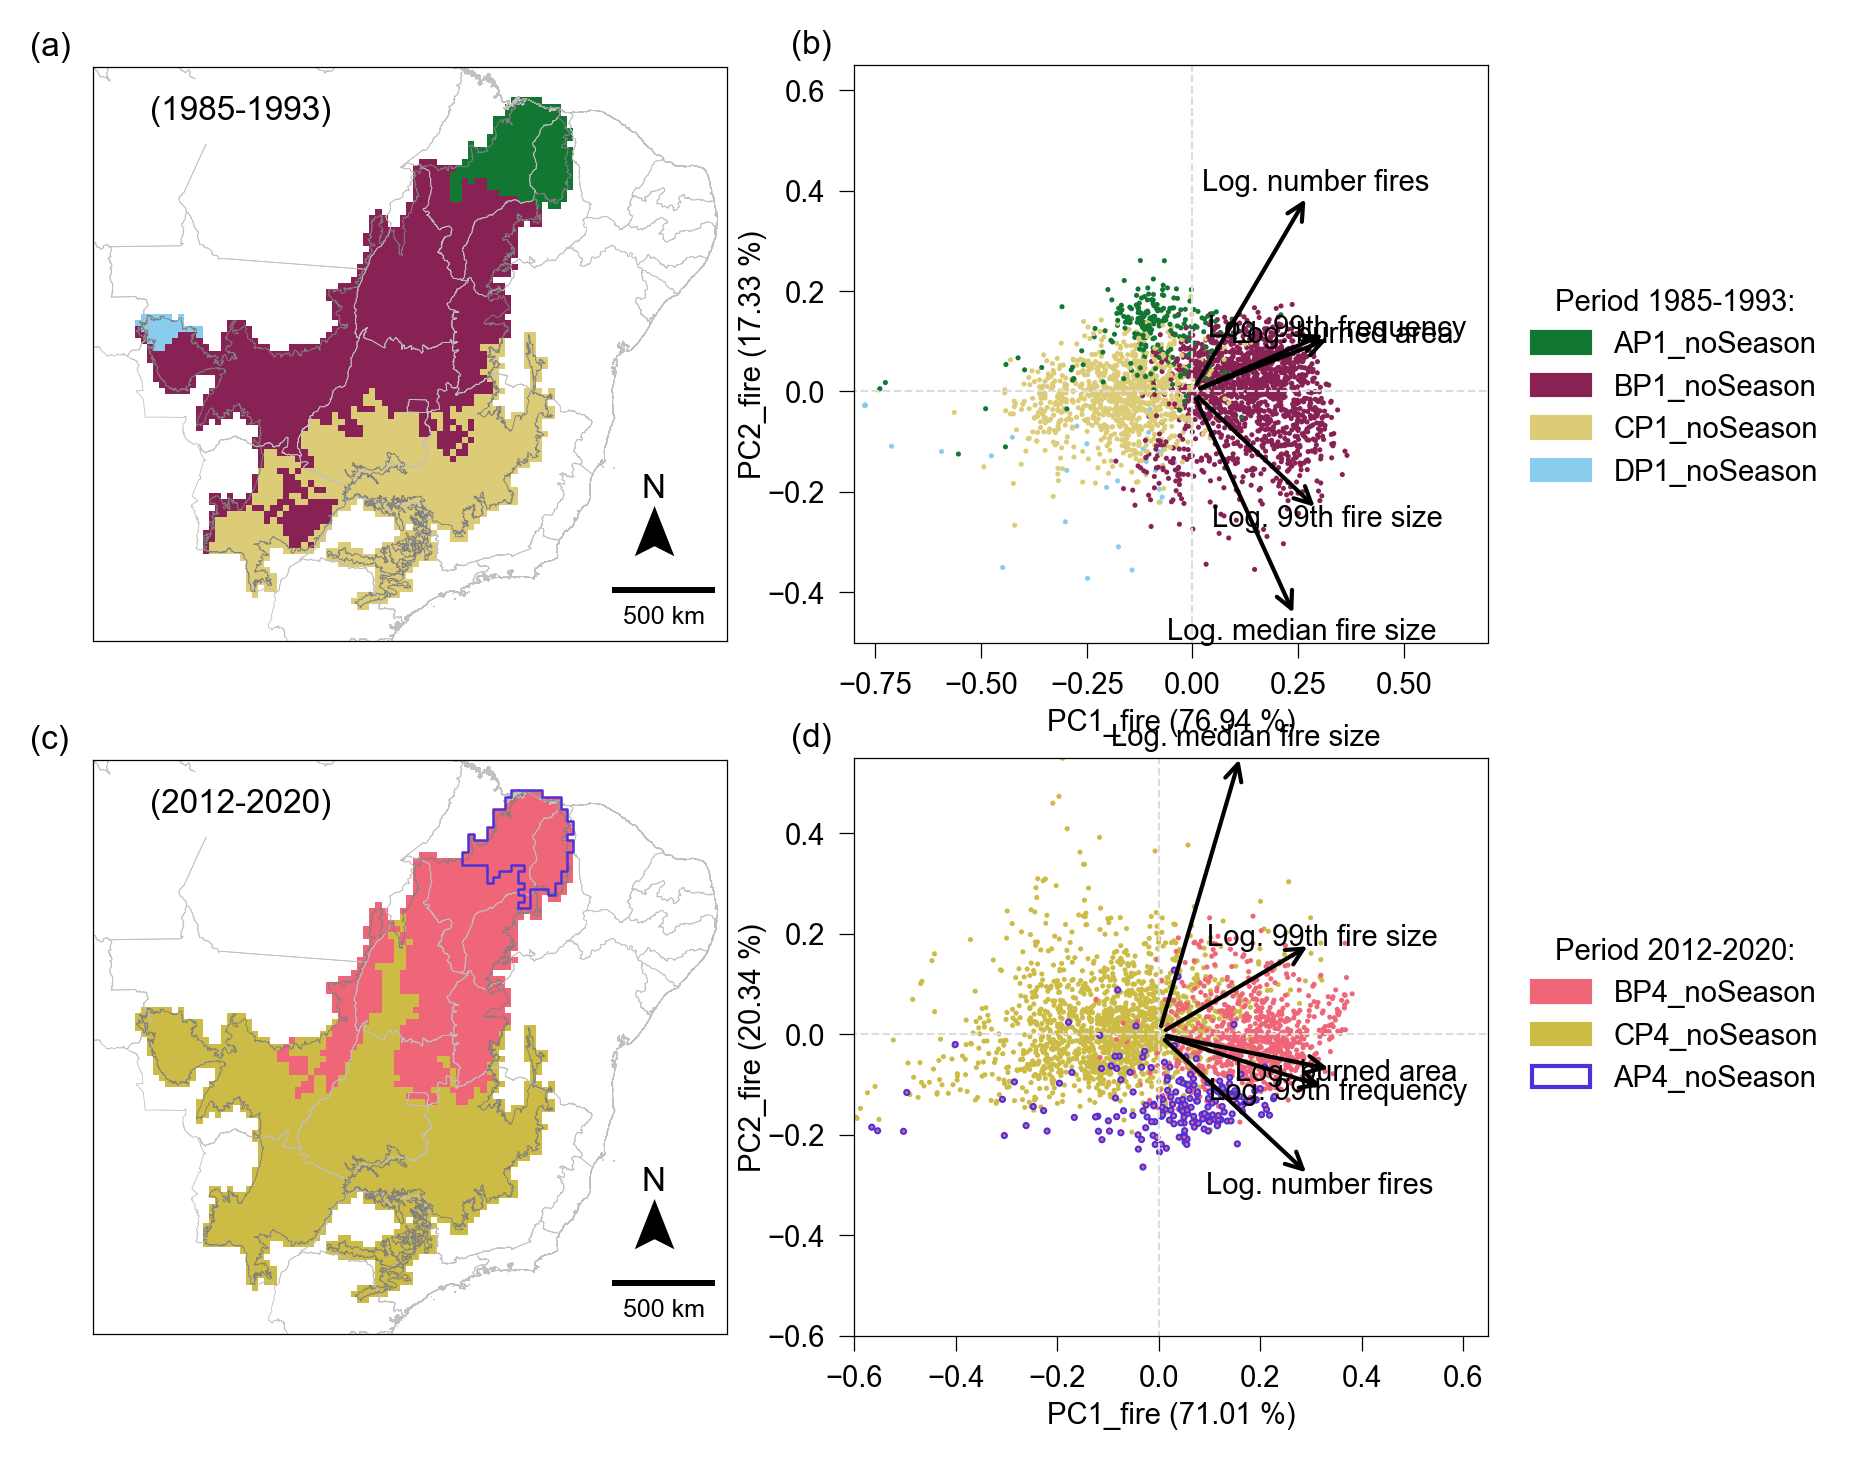

In [65]:
fig, axes = plt.subplots(2, 2, figsize = (6., 5.5))

pca_lim = [((-0.8, 0.7), (-0.5, 0.65)), ((-0.6, 0.65), (-0.6, 0.55))]

fig_label = ['(a)', '(c)', '(b)',  '(d)']

# Plot for each solution (number of clusters)
i = 0
for i, period, k, p_label, (xlim, ylim) in zip(range(2), [1, 4], [4, 2], ['(1985-1993)', '(2012-2020)'], pca_lim):
    
    toPlot = data['p{}'.format(period)].copy()
    
    # Inverting x-axes of period's 4 PCA
    if period == 4:
        toPlot['PC1'] = (-1) * toPlot['PC1']
    
    # ----------------------------------------------------------------------------------------------------------------------
    # Map on top
    toPlot.plot(color = toPlot['colors_{}'.format(k)], ax = axes[i][0], legend = True)
    # axes[i][0].set_axis_off()
    # axes[i][0].set_title(p_label, fontsize = 8)
    
    br_states = gpd.read_file('../../data/shapes/brazilian_states/gadm36_BRA_1.shp')
    br_states = br_states.to_crs(toPlot.crs)
    br_states.boundary.plot(ax = axes[i][0], linewidth=0.2, edgecolor = 'silver')
    

    cerrado = gpd.read_file('../../data/shapes/cerrado_1-250000.shp')
    cerrado = cerrado.to_crs(toPlot.crs)
    cerrado.boundary.plot(ax = axes[i][0], linewidth=0.2, edgecolor = 'grey')
    
    minx, miny, maxx, maxy = toPlot.total_bounds
    axes[i][0].set_xlim(minx-200000, maxx+750000)
    axes[i][0].set_ylim(miny-150000, maxy+150000)
    
    
    # Adding figure label
    axes[i][0].text(x=-0.1, y=1.02, s=fig_label[i], transform=axes[i][0].transAxes, fontsize=8)
    
    axes[i][0].tick_params(axis='both', 
                            which='both',
                            bottom=False,
                            left = False,
                            labelbottom=False, labelleft = False)
    
    # Change width of all spines of axis
    for axis in ['top','bottom','left','right']:
        axes[i][0].spines[axis].set_linewidth(0.3)
        
    # Adding label with the period
    axes[i][0].text(0.375, 0.95, p_label, transform = axes[i][0].transAxes, fontsize=8, bbox = {'edgecolor': 'white', 'facecolor':'white', 'linewidth':0.2}, va = 'top', ha = 'right') # , backgroundcolor='white'
    
    # Including an arrow
    axes[i][0].text(x=0.865, y=0.25, s='N', transform=axes[i][0].transAxes, fontsize=8)
    # 0.055 for the 4-grid, 0.05 for the 3-grid
    axes[i][0].arrow(0.885, 0.175, 0.0, 0.05, length_includes_head=True, transform=axes[i][0].transAxes,
              width = 0, head_width=0.05, head_length=0.07, overhang=0.2, facecolor='k')
    
    # Taken from the GeoPandas documentation: https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html 
    points = gpd.GeoSeries([Point(-45, -10.0), Point(-46, -10.0)], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs('epsg:5880') # Projected WGS 84 - meters
    distance_meters = points[0].distance(points[1])

    # axes[i][0].add_artist(ScaleBar(distance_meters, location='lower right', font_properties={'size': 8}, sep = 3))
    axes[i][0].add_artist(ScaleBar(dx = 1, units = 'm', dimension = 'si-length',  location='lower right', font_properties={'size': 6}, sep = 3))
    
    # Add zone that is a bit special
    if period == 4:
        subset = toPlot[toPlot['clust_{}'.format(4)] == 4]
        subset.dissolve().boundary.plot(color = '#4c31db', ax = axes[i][0], linewidth = 0.6)
    # ----------------------------------------------------------------------------------------------------------------------
    # PCA at the bottom
    
    # Setting the limits of the axis manually
    axes[i][1].set_xlim(xlim)
    axes[i][1].set_ylim(ylim)
    
    # Adding vertical and horizontal lines
    axes[i][1].axvline(0, -1, 1, linestyle = '--', linewidth = 0.5, color = 'gainsboro')
    axes[i][1].axhline(0, -1, 1, linestyle = '--', linewidth = 0.5, color = 'gainsboro')
    
    # Adding figure label
    axes[i][1].text(x=-0.1, y=1.02, s=fig_label[i+2], transform=axes[i][1].transAxes, fontsize=8)
    
    # The data points
    _plot = sns.scatterplot(x = toPlot['PC1'],
                    y = toPlot['PC2'],
                    hue = toPlot['clust_alpha_{}'.format(k)], 
                    ax = axes[i][1], s = 1.5, edgecolor = 'none', legend = None, palette = pal_p14['p{}'.format(period)])
    
    pca_exp_x = np.round(pca_exp.loc[pca_exp['period'] == period, 'PC1'].item(), decimals = 2)
    pca_exp_y = np.round(pca_exp.loc[pca_exp['period'] == period, 'PC2'].item() - pca_exp_x, decimals = 2)
    
    axes[i][1].set_xlabel('PC1_fire ({} %)'.format(pca_exp_x), fontsize = 7, labelpad = 2)
    axes[i][1].set_ylabel('PC2_fire ({} %)'.format(pca_exp_y), fontsize = 7, labelpad = 0.25)
    
    
    # Changing width of plot lines
    axes[i][1].tick_params(axis='both', which='major', labelsize=7, width = 0.3)
    # Change width of all spines of axis
    for axis in ['top','bottom','left','right']:
        axes[i][1].spines[axis].set_linewidth(0.3)
        
    # Adding the arrows
    comp = pca_comp['p{}'.format(period)].copy()
    # Inverting x-axes for period 4
    if period == 4:
        comp['PC1'] = (-1)* comp['PC1']
    for c in range(len(comp)):
        sc = 16
        # axes[i][1].arrow(0, 0, comp.loc[c,'PC1']/sc, comp.loc[c, 'PC2']/sc, color = 'r', width = 0.0001)
        axes[i][1].annotate('', xy = (0, 0),# xycoords = 'data',
                  xytext = (comp.loc[c,'PC1']/sc, comp.loc[c, 'PC2']/sc),# textcoords = 'data',
                  arrowprops = {'arrowstyle':'<-','edgecolor' : 'black', 'facecolor': 'black'})

        axes[i][1].text(comp.loc[c,'PC1']*1.05/sc, comp.loc[c, 'PC2']*1.05/sc, comp.loc[c, 'id_label'], fontsize = 7, color = 'black', ha = 'center', va = 'center')
        
    # Add zone that is a bit special
    if period == 4:
        subset = toPlot[toPlot['clust_{}'.format(4)] == 4].reset_index(drop = True)
        # The data points
        sns.scatterplot(x = subset['PC1'],
                        y = subset['PC2'],
                        hue = subset['clust_alpha_{}'.format(k)], 
                        ax = axes[i][1], s = 1.5,  legend = None, palette = pal_p14['p{}'.format(period)], linewidth = 0.5, edgecolor = '#4c31db')
    del toPlot, comp
        
    i += 1
    
    
# Create legend manually
patches_p1 = [Patch(color = c, label = l) for c, l in zip(pal_p14['p1'].values(), pal_p14['p1'].keys())]
patches_p4 = [Patch(color = c, label = l) for c, l in zip(pal_p14['p4'].values(), pal_p14['p4'].keys())] + [Patch(facecolor = 'white', edgecolor = '#4c31db', label = 'AP4_noSeason')]

legend_contents = [Patch(visible = False, label = 'Period 1985-1993:')] + patches_p1 + [Patch(visible = False, label = ''), Patch(visible = False, label = 'Period 2012-2020:')] + patches_p4

legend_p1 = plt.legend(handles = patches_p1, title ='Period 1985-1993:', loc = (1.05, 1.45), fontsize = 7, title_fontsize = 7, frameon = False)
plt.legend(handles = patches_p4, title ='Period 2012-2020:', loc = (1.05, .4), fontsize = 7, title_fontsize = 7, frameon = False)
plt.gca().add_artist(legend_p1)

plt.savefig('../plots_colorblind/noSeason_map_PCA_periods1_4.svg', dpi=300, facecolor='white', transparent=False, bbox_inches="tight")
plt.savefig('../plots_colorblind/noSeason_map_PCA_periods1_4.pdf', dpi=300, facecolor='white', transparent=False, bbox_inches="tight")
plt.show()